In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('eda_data.csv')
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,age,python_des.,R_studio_des.,spark_des.,aws_des.,excel_des.,jobs_simp,seniority,des_length,num_comp
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,47,1,0,0,0,1,data scientist,na,2555,0
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,36,1,0,0,0,0,data scientist,na,4828,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,...,10,1,0,1,0,1,data scientist,na,3495,0
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,...,55,1,0,0,0,0,data scientist,na,3926,3
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,...,22,1,0,0,0,1,data scientist,na,2748,3


In [21]:
# chose relevant columns

df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','Employer_provider',
             'jobs_state','same_state','age','python_des.','spark_des.','aws_des.','excel_des.','jobs_simp','seniority','des_length']]


# get dummy data

df_dum = pd.get_dummies(df_model)

# train test split
from sklearn.model_selection import train_test_split
X = df_dum.drop("avg_salary", axis = 1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)








In [22]:
# multiple linear regression

import statsmodels.api as sm
X_sm = X = sm.add_constant(X)
model = sm.OLS(y, X_sm)
model.fit().summary()


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train, y_train)

print(np.mean(cross_val_score(lm,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))


-141003559.52420467


,alpha,error
12,0.13,-19.274324


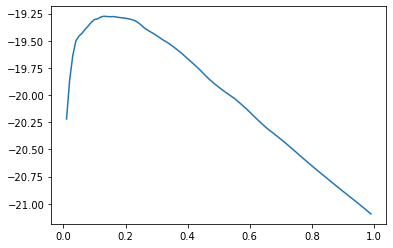

In [23]:
# lasso regression
lm_l = Lasso(alpha=.13)
lm_l.fit(X_train,y_train)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

In [24]:
# random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

print(np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3)))


-14.939619502982447


In [28]:
# tune this model using GridsearchCv
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

gs.best_score_
gs.best_estimator_

KeyboardInterrupt: 

In [ ]:
# test ensembles
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,tpred_lm)
mean_absolute_error(y_test,tpred_lml)
mean_absolute_error(y_test,tpred_rf)

print(mean_absolute_error(y_test,(tpred_lm+tpred_rf)/2))

import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])